# plot simulated and observed groundwater level at given well

In [295]:
# inline plot
# %matplotlib inline 
# interactive plot
%matplotlib notebook  
import numpy as np
import h5py as h5
import glob
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
# plt.style.use('ggplot')
plt.style.use('fast')
# inline_rc = dict(mpl.rcParams)
# mpl.rcParams.update(inline_rc) 
import matplotlib.gridspec as gridspec
from datetime import datetime, timedelta
import pandas as pd
import ipdb
from scipy import interpolate
import pickle
from ipyleaflet import *
import ipywidgets as ipyw
import pyproj
import json
from geojson import Feature, FeatureCollection, Point
import mplleaflet
import geopandas
from geopandas import GeoDataFrame
from shapely.geometry import Point
import fiona

In [2]:
def batch_delta_to_time(origin, x, time_format, delta_format):
    y = []
    for ix in x:
        if delta_format == "hours":
            temp_y = origin + timedelta(hours=ix)
        elif delta_format == "days":
            temp_y = origin + timedelta(days=ix)
        elif delta_format == "minutes":
            temp_y = origin + timedelta(minutes=ix)
        elif delta_format == "weeks":
            temp_y = origin + timedelta(weeks=ix)
        elif delta_format == "seconds":
            temp_y = origin + timedelta(seconds=ix)
        elif delta_format == "microseconds":
            temp_y = origin + timedelta(microseconds=ix)
        elif delta_format == "milliseconds":
            temp_y = origin + timedelta(milliseconds=ix)
        else:
            print("Sorry, this naive program only solve single time unit")
        y.append(temp_y.strftime(time_format))
    y = np.asarray(y)
    return(y)

In [3]:
# print both group and its member names
def printname(name):
    print(name)

## I/O files and parameters

In [237]:
#input
model_dir = "/Users/shua784/Paraview/HFR/HFR_model_200x200x2_6h_bc/"
fname_model_origin = model_dir + "model_origin.txt"
fname_material_h5 = model_dir + "HFR_material_river.h5"
fname_pflotran_h5 = model_dir + "pflotran_200x200x2_6h_bc_test.h5"
fname_300A_h5 = "/Users/shua784/Paraview/300A/John_case_optim_5/pflotran_bigplume-004.h5"

data_dir = "/Users/shua784/Dropbox/PNNL/Projects/Reach_scale_model/data/"
fname_mass1_coord = data_dir + "MASS1/coordinates.csv"
fname_300A_well_screen = data_dir + "well_data/300A_Monitoring_Well_Screen.csv"
fname_300A_well_data = data_dir + 'well_data/SFA_all_wells.csv'
fname_300A_spc_u = data_dir + 'well_data/Sample_Data_2015_U.csv'
fname_HEIS_well_screen = data_dir + 'well_data/wellCasingAndScreen.csv'
fname_HEIS_300A_screen = data_dir + 'well_data/HEIS_300A_well_screen.csv'
fname_HEIS_auto_well = data_dir + 'well_data/mvAwln.csv'
fname_HEIS_manual_well = data_dir + 'well_data/HYDRAULIC_HEAD_MV.csv'
fname_GW_chem = data_dir + 'well_data/GW_SAMPLE_RESULT_MV.csv'
fname_GW_NO3 = data_dir + 'well_data/GW_nitrate.csv'
fname_GW_NH4 = data_dir + 'well_data/GW_ammonium.csv' 
fname_GW_Cr = data_dir + 'well_data/GW_chromium.csv'
fname_GW_As = data_dir + 'well_data/GW_arsenic.csv'
fname_GW_spc = data_dir + 'well_data/GW_SpC.csv'
fname_GW_NO3_coord = data_dir + 'well_data/GW_chemistry/Nitrate_summary.csv'
fname_GW_NO3_geojson = data_dir + 'well_data/GW_chemistry/Nitrate_geojson.json'

#output
out_dir = "/Users/shua784/Dropbox/PNNL/Projects/Reach_scale_model/Outputs/HFR_model_200x200x2_6h_bc/"
fig_wl = out_dir + 'wl/'
fig_simu_obs_wl = out_dir + "simu_obs_wl/"
fig_tracer_spc = out_dir + "tracer_spc/"
fig_nitrate = out_dir + "nitrate/"



result_dir = "/Users/shua784/Dropbox/PNNL/Projects/Reach_scale_model/results/HFR_model_200x200x2_6h_bc/"
fname_well_simu_data_pk = result_dir + "well_simu_data.p"


In [5]:
P_atm = 101325
rho = 997.16
g_const = 9.81

z_bot = 0
z_top = 200


In [8]:
date_origin = datetime.strptime("2007-03-28 00:00:00", "%Y-%m-%d %H:%M:%S")
# read model origin
model_origin = np.genfromtxt(fname_model_origin, delimiter=" ", skip_header=1)

## combine files
combine 300A well screen with HEIS well screen data

In [395]:
screen_300A = pd.read_csv(fname_300A_well_screen, index_col=['Well_ID'])
screen_HEIS = pd.read_csv(fname_HEIS_well_screen, index_col=['Well_ID'])

screen_HEIS_copy = screen_HEIS[['WellName', 'EASTING', 'NORTHING', 'TopCasing', 'TopScreen', 'BottomScreen']]
# rename columns
screen_HEIS_copy.columns = ['WellName', 'Easting', 'Northing', 'CASING_ELEVATION', 'SCREEN_ELEV_TOP', 'SCREEN_ELEV_BOTTOM']
# remove duplicates and NaN
screen_300A_HEIS = screen_300A.append(screen_HEIS_copy).drop_duplicates('WellName', keep='first') \
                                .dropna(subset=['SCREEN_ELEV_TOP', 'SCREEN_ELEV_BOTTOM']) \
                                .sort_values(by = 'index')
# save to csv file
screen_300A_HEIS.to_csv(fname_HEIS_300A_screen)

## import well data

In [9]:
# import obs well screen information
well_loc = pd.read_csv(fname_300A_well_screen, index_col= ['WellName'])
# print(well_loc.head(5))
screen_300A_HEIS = pd.read_csv(fname_HEIS_300A_screen, index_col=['WellName'])

screen_300A_HEIS['Easting'] = screen_300A_HEIS['Easting'] - model_origin[0]
screen_300A_HEIS['Northing'] = screen_300A_HEIS['Northing'] - model_origin[1]

well_loc['Easting'] = well_loc['Easting'] - model_origin[0]
well_loc['Northing'] = well_loc['Northing'] - model_origin[1]

In [10]:
well_screen = screen_300A_HEIS.copy()

In [11]:
# import obs well data
well_data = pd.read_csv(fname_300A_well_data)
# print(well_data.head(5))
HEIS_auto = pd.read_csv(fname_HEIS_auto_well)
HEIS_manual = pd.read_csv(fname_HEIS_manual_well)

spc_u_data = pd.read_csv(fname_300A_spc_u)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (21,22) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [19]:
HEIS_manual.rename(columns={'WELL_ID':'Well_ID', 'WELL_NAME': 'WellName', 'HYD_DATE_TIME_PST':'DateTime', \
                           'HYD_HEAD_METERS_NAVD88':'WL'}, inplace = True)

spc_u_data.rename(columns={'well ID':'WellName', 'date/time':'DateTime', 'Temp(degrees C)':'Temp', \
                           'SpC(uS/cm)':'Spc', 'U (ug/L)':'U'}  , inplace=True)

HEIS_auto.rename(columns={'WellNumber':'Well_ID', 'procWaterElevation':'WL', 'procDate':'DateTime'}, inplace=True)

In [147]:
# import groundwater chemistry data
GW_chem = pd.read_csv(fname_GW_chem)

GW_chem.rename(columns={'SAMP_DATE_TIME': 'DateTime', 'STD_CON_LONG_NAME':'Chemical', \
                        'STD_VALUE_RPTD':'Concentration', 'STD_ANAL_UNITS_RPTD':'Unit', \
                       'SAMP_SITE_NAME': 'WellName', 'SAMP_SITE_ID':'Well_ID'}, inplace=True)

GW_chem['DateTime'] = GW_chem['DateTime'].apply(pd.to_datetime)

# # split one column to two separate columns
# GW_chem['WellName'] = GW_chem['WellName_ID'].str.split('[()]').str[0]
# GW_chem['Well_ID']= GW_chem['WellName_ID'].str.split('[()]').str[1]

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (8,9,10,22,23,27,28,31,33,34,39,41,48,51,59,60,64,65,66,67,70,71,83,84,87,88) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [148]:
chemicals = list(GW_chem.Chemical.unique())
chemicals.sort()

selected_chemicals = ['Specific Conductance', 'pH Measurement', 'Temperature', 'Nitrate', \
                     'Chromium', 'Turbidity', 'Nitrite', 'Arsenic', 'Uranium']

# save each chemical as file
for ichemical in selected_chemicals[:]:
    table = GW_chem[GW_chem.loc[:,'Chemical'] == ichemical].copy()
    
    if '/' in ichemical:
        fname = data_dir + 'well_data/GW_chemistry/' + ichemical.replace('/',' ') + '.csv'
    else:
        fname = data_dir + 'well_data/GW_chemistry/' + ichemical + '.csv'
    
    table.to_csv(fname)

rename column names to contain the following label : **Well_ID, WellName, DateTime, WL**

In [20]:
# read mass1 coordinates
section_coord = np.genfromtxt(
    fname_mass1_coord, delimiter=",", skip_header=1)
section_coord[:, 1] = section_coord[:, 1] - model_origin[0]
section_coord[:, 2] = section_coord[:, 2] - model_origin[1]
line1 = section_coord[0, 1:3] / 1000
line2 = section_coord[int(len(section_coord[:, 1]) / 2), 1:3] / 1000
line3 = section_coord[-1, 1:3] / 1000

line1_x = [line1[0]] * 2
line1_y = [line1[1] - 5, line1[1] + 5]
line2_x = [line2[0] - 5, line2[0] + 5]
line2_y = [line2[1]] * 2
line3_x = [line3[0] - 5, line3[0] + 5]
line3_y = [line3[1]] * 2

## read model dim, time index from hdf5 output file

In [21]:
# all_h5 = glob.glob(fname_pflotran_h5) # find all "pflotran*.h5" files
# all_h5 = np.sort(all_h5)

input_h5 = h5.File(fname_pflotran_h5, "r")

# input_h5.visit(printname)

x_grids = list(input_h5["Coordinates"]['X [m]'])
y_grids = list(input_h5["Coordinates"]['Y [m]'])
z_grids = list(input_h5["Coordinates"]['Z [m]'])
# input_h5.close()

dx = np.diff(x_grids)
dy = np.diff(y_grids)
dz = np.diff(z_grids)

nx = len(dx)
ny = len(dy)
nz = len(dz)

# x,y,z coordinates at cell center
x = x_grids[0] + np.cumsum(dx) - 0.5 * dx[0]
y = y_grids[0] + np.cumsum(dy) - 0.5 * dy[0]
z = z_grids[0] + np.cumsum(dz) - 0.5 * dz[0]

# generate mesh grid
xx, yy = np.meshgrid(x, y)

# create grids (nx*ny*nz, 3)--a list of arrays based nx, ny, nz
grids = np.asarray([(x, y, z) for z in range(nz)
                    for y in range(ny) for x in range(nx)])

groups = list(input_h5.keys()) # create a list with group names
time_index = [s for s, s in enumerate(groups) if "Time:" in s] # enumerate returns its index (index, string)

In [22]:
real_time_index = []
for itime in np.arange(len(time_index)):
    itime_str = list(batch_delta_to_time(date_origin, [float(time_index[itime][7:18])], "%Y-%m-%d %H:%M:%S", "hours"))
    itime_str = ''.join(itime_str)
    real_time_index.append(datetime.strptime(itime_str, "%Y-%m-%d %H:%M:%S"))

## read river cell information from material h5 file

In [23]:
# open file for reading
material_h5 = h5.File(fname_material_h5, "r") 
# read river cell ids
river_cells = []
for i_region in list(material_h5['Regions'].keys()):
    river_cells = np.append(river_cells, np.asarray(
        list(material_h5["Regions"][i_region]["Cell Ids"])))
river_cells = np.unique(river_cells).astype(int)
river_cells = river_cells - 1  # need minus 1 as python index started with 0
# label river cells in x-y plane with '1'
yx_river = np.asarray([np.nan] * (ny * nx)).reshape(ny, nx) # initialize ny*nx array with nan value, because python read column first (y,x)
for icell in river_cells:
    yx_river[grids[icell, 1], grids[icell, 0]] = 1
    
material_h5.close()

## calculate simulated head
We can calculate total head by $$H = h + z, (h = (P-P_{atm})/\gamma/g)$$  
which $h$ has shape of **(100, 300, 300)**, and $z$ has shape of **(100,)**. To use broadcasting rule, the dimension of two arrays must match or either one has $dim = 1$. In this case, $z$ is reshaped to **(100, 1, 1)**. that is $$ H(100, 300, 300) = h(100,300,300) + z(100, 1, 1) $$


note: when importing hdf5 dataset of dimension **(nx, ny, nz)**, the shape of numpy array will be **(nx, ny, nz)**. The correct logical shape in numpy would need to change to **(nz, ny, nx)** by using `np.swapaxes(0, 2)`.

### Using interpolation to get well obs data at given location
notes about using scipy.interpolate:
* `interpolate.Rbf` performs best for irregular dataset compared to `interpolate.interp2d` and `interpolate.griddata` and can do both interpolation and extrapolation, however, it is **extremely slow** for large dataset. (see this [post](https://stackoverflow.com/questions/37872171/how-can-i-perform-two-dimensional-interpolation-using-scipy))
* `interpolate.RectBivariateSpline` is fast for structured grid, however, it will return NaN if there is missing data in the inputs. A work around is to replace those missing data with 0 or -9999. After interpolation, set those missing data to NaN again. (see this [post](https://stackoverflow.com/questions/15485343/bivariate-structured-interpolation-of-large-array-with-nan-values-or-mask)) (_note: this method can create some erratic numbers (negative concentration)_)
* `interpolate.griddata` interpolate scatter points to a regular grid. It does not perform extrapolation. Need to test its performance against large dataset.



Initialize arrays...
Be careful using `np.empty()`, it will generate random number in the array.

In [24]:
well_simu_head = np.zeros((len(time_index), nz, len(well_screen.index))) # initialize array to store simu.head at obs.wells
well_xflux = np.zeros((len(time_index), nz, len(well_screen.index))) # initialize array to store abs.flux at obs.wells
well_yflux = np.zeros((len(time_index), nz, len(well_screen.index))) # initialize array to store abs.flux at obs.wells
well_ave_tracer = np.zeros((len(time_index), len(well_screen.index))) # store flux-average tracer conc.
well_tracer = np.zeros((len(time_index), nz, len(well_screen.index))) # initialize array to store tracer conc. at obs.wells

# create index for well screen intervals range within model domain
interval_index = np.where((z >= np.min(well_screen['SCREEN_ELEV_BOTTOM'])) \
                          & (z <= np.max(well_screen['SCREEN_ELEV_TOP'])))
interval_index = np.asarray(interval_index).flatten()

In [31]:
# loop over time step
for itime in np.arange(len(time_index))[:]:
#         ipdb.set_trace()
    print(time_index[itime])
    real_itime = batch_delta_to_time(date_origin, [float(time_index[itime][7:18])], "%Y-%m-%d %H:%M:%S", "hours")
    real_itime = str(real_itime)
    print(real_itime, type(real_itime))
    # read pressure
    temp_pressure = np.asarray(list(input_h5[time_index[itime]]["Liquid_Pressure [Pa]"])).swapaxes(0,2)
    temp_pressure[temp_pressure == 0] = np.nan # replace 0 (inactive cell pressure) with nan to avoid calculations

    # convert liquid_pressure to pressure head
    temp_head = (temp_pressure - P_atm) / rho / g_const
    # reshape z to use broadcasting rule
    z_reshape = z.reshape(nz, 1, 1)
    # total head  = presure head + elevation head
    temp_total_head = temp_head + z_reshape

    # create a copy of total_head and replace nan with 0
    total_head_copy = temp_total_head.copy()
    total_head_copy = np.nan_to_num(total_head_copy) # replace nan with 0 for interpolation
    
    # calculate ave. tracer conc. at wells
    xflux = np.asarray(list(input_h5[time_index[itime]]['Liquid X-Flux Velocities'])).swapaxes(0,2) 
    yflux = np.asarray(list(input_h5[time_index[itime]]['Liquid Y-Flux Velocities'])).swapaxes(0,2)

    
    temp_tracer = np.asarray(list(input_h5[time_index[itime]]['Total_Tracer [M]'])).swapaxes(0,2)
#     temp_tracer[temp_tracer == 0] = np.nan
    # interpolate head at each iz layer
    for iz in interval_index:
        f_head = interpolate.RectBivariateSpline(y, x, total_head_copy[iz, :,:])
        f_xflux = interpolate.RectBivariateSpline(y, x_grids[1:-1], xflux[iz, :,:]) #x-flux shape is different from y-flux shape
        f_yflux = interpolate.RectBivariateSpline(y_grids[1:-1], x, yflux[iz, :,:])        
        f_tracer = interpolate.RectBivariateSpline(y, x, temp_tracer[iz, :,:])
#         f_tracer = interpolate.SmoothBivariateSpline(yy.flatten(), xx.flatten(), temp_tracer[iz, :,:].flatten())        
        # evaluate at well points
        well_simu_head[itime, iz, :] = f_head.ev(well_screen['Northing'], well_screen['Easting']) 

        well_xflux[itime, iz, :] = f_xflux.ev(well_screen['Northing'], well_screen['Easting'])
        well_yflux[itime, iz, :] = f_yflux.ev(well_screen['Northing'], well_screen['Easting'])
        
        well_tracer[itime, iz, :] = f_tracer.ev(well_screen['Northing'], well_screen['Easting']) # has negative value?
    
    well_tracer[well_tracer < 0] = np.nan     
    # calculate flux averageing tracer at each well
    for iwell in well_screen.index[:]:
    #     iwell = '399-1-10A'
#         print(iwell)
        iwell_abs_flux = []
        iwell_screen_index = np.asarray(np.where(well_screen.index == iwell)).flatten()
        iwell_interval_index = np.where((z > well_screen.loc[iwell, 'SCREEN_ELEV_BOTTOM']) \
                                        & (z < well_screen.loc[iwell, 'SCREEN_ELEV_TOP']))
        iwell_interval_index = np.asarray(iwell_interval_index).flatten()
        
        iwell_abs_flux = np.sqrt(well_xflux[itime, iwell_interval_index, iwell_screen_index]**2 + \
                                well_yflux[itime, iwell_interval_index, iwell_screen_index]**2)
        iwell_abs_flux = np.asarray(iwell_abs_flux).flatten()
        well_ave_tracer[itime, iwell_screen_index] = np.sum(iwell_abs_flux*well_tracer[itime, iwell_interval_index, \
                                                                                       iwell_screen_index])/np.sum(iwell_abs_flux)

Time:  3.24000E+04 h
['2010-12-07 00:00:00'] <class 'str'>


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in double_scalars


Time:  3.25200E+04 h
['2010-12-12 00:00:00'] <class 'str'>


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in less


Time:  3.26400E+04 h
['2010-12-17 00:00:00'] <class 'str'>
Time:  3.27600E+04 h
['2010-12-22 00:00:00'] <class 'str'>
Time:  3.28800E+04 h
['2010-12-27 00:00:00'] <class 'str'>
Time:  3.30000E+04 h
['2011-01-01 00:00:00'] <class 'str'>
Time:  3.31200E+04 h
['2011-01-06 00:00:00'] <class 'str'>
Time:  3.32400E+04 h
['2011-01-11 00:00:00'] <class 'str'>
Time:  3.33600E+04 h
['2011-01-16 00:00:00'] <class 'str'>
Time:  3.34800E+04 h
['2011-01-21 00:00:00'] <class 'str'>
Time:  3.36000E+04 h
['2011-01-26 00:00:00'] <class 'str'>
Time:  3.37200E+04 h
['2011-01-31 00:00:00'] <class 'str'>
Time:  3.38400E+04 h
['2011-02-05 00:00:00'] <class 'str'>
Time:  3.39600E+04 h
['2011-02-10 00:00:00'] <class 'str'>
Time:  3.40800E+04 h
['2011-02-15 00:00:00'] <class 'str'>
Time:  3.42000E+04 h
['2011-02-20 00:00:00'] <class 'str'>
Time:  3.43200E+04 h
['2011-02-25 00:00:00'] <class 'str'>
Time:  3.44400E+04 h
['2011-03-02 00:00:00'] <class 'str'>
Time:  3.45600E+04 h
['2011-03-07 00:00:00'] <class 'str

Time:  4.93200E+04 h
['2012-11-11 00:00:00'] <class 'str'>
Time:  4.94400E+04 h
['2012-11-16 00:00:00'] <class 'str'>
Time:  4.95600E+04 h
['2012-11-21 00:00:00'] <class 'str'>
Time:  4.96800E+04 h
['2012-11-26 00:00:00'] <class 'str'>
Time:  4.98000E+04 h
['2012-12-01 00:00:00'] <class 'str'>
Time:  4.99200E+04 h
['2012-12-06 00:00:00'] <class 'str'>
Time:  5.00400E+04 h
['2012-12-11 00:00:00'] <class 'str'>
Time:  5.01600E+04 h
['2012-12-16 00:00:00'] <class 'str'>
Time:  5.02800E+04 h
['2012-12-21 00:00:00'] <class 'str'>
Time:  5.04000E+04 h
['2012-12-26 00:00:00'] <class 'str'>
Time:  5.05200E+04 h
['2012-12-31 00:00:00'] <class 'str'>
Time:  5.06400E+04 h
['2013-01-05 00:00:00'] <class 'str'>
Time:  5.07600E+04 h
['2013-01-10 00:00:00'] <class 'str'>
Time:  5.08800E+04 h
['2013-01-15 00:00:00'] <class 'str'>
Time:  5.10000E+04 h
['2013-01-20 00:00:00'] <class 'str'>
Time:  5.11200E+04 h
['2013-01-25 00:00:00'] <class 'str'>
Time:  5.12400E+04 h
['2013-01-30 00:00:00'] <class 'str

Time:  6.60000E+04 h
['2014-10-07 00:00:00'] <class 'str'>
Time:  6.61200E+04 h
['2014-10-12 00:00:00'] <class 'str'>
Time:  6.62400E+04 h
['2014-10-17 00:00:00'] <class 'str'>
Time:  6.63600E+04 h
['2014-10-22 00:00:00'] <class 'str'>
Time:  6.64800E+04 h
['2014-10-27 00:00:00'] <class 'str'>
Time:  6.66000E+04 h
['2014-11-01 00:00:00'] <class 'str'>
Time:  6.67200E+04 h
['2014-11-06 00:00:00'] <class 'str'>
Time:  6.68400E+04 h
['2014-11-11 00:00:00'] <class 'str'>
Time:  6.69600E+04 h
['2014-11-16 00:00:00'] <class 'str'>
Time:  6.70800E+04 h
['2014-11-21 00:00:00'] <class 'str'>
Time:  6.72000E+04 h
['2014-11-26 00:00:00'] <class 'str'>
Time:  6.73200E+04 h
['2014-12-01 00:00:00'] <class 'str'>
Time:  6.74400E+04 h
['2014-12-06 00:00:00'] <class 'str'>
Time:  6.75600E+04 h
['2014-12-11 00:00:00'] <class 'str'>
Time:  6.76800E+04 h
['2014-12-16 00:00:00'] <class 'str'>
Time:  6.78000E+04 h
['2014-12-21 00:00:00'] <class 'str'>
Time:  6.79200E+04 h
['2014-12-26 00:00:00'] <class 'str

dump files using `pickle.dump` and load files using `pickle.load`

In [34]:
# saving objects
with open(fname_well_simu_data_pk, "wb") as f:
    pickle.dump((well_simu_head, well_xflux, well_yflux, well_tracer, well_ave_tracer), f)
# # loading objects    
# with open(fname_well_simu_data_pk, "rb") as f:
#     well_simu_head, well_xflux, well_yflux, well_tracer, well_ave_tracer = pickle.load(f)

### plot well simu vs obs head

In [109]:
%matplotlib inline 
for iwell in well_screen.index[17:]:
#     iwell = '399-2-10'
    print(iwell)
    iwell_screen_index = np.asarray(np.where(well_screen.index == iwell)).flatten()
    iwell_interval_index = np.where((z >= well_screen.loc[iwell, 'SCREEN_ELEV_BOTTOM']) \
                                    & (z <= well_screen.loc[iwell, 'SCREEN_ELEV_TOP']) \
                                   )
    iwell_interval_index = np.asarray(iwell_interval_index).flatten()
    # well head is taken at the lowest screen interval--iwell_interval_index[0]
    
    if iwell_interval_index.size > 0:
        isimu_head = well_simu_head[:, iwell_interval_index[0], iwell_screen_index]
        isimu_head = isimu_head.reshape(isimu_head.shape[0])
    
    # read obs.head
    if iwell in well_data['WellName'].unique():
        iobs_head_df = well_data[ well_data.loc[:, 'WellName'] == iwell].copy()
        iobs_head_df['DateTime'] = iobs_head_df['DateTime'].apply(pd.to_datetime)
    elif iwell in HEIS_auto['WellName'].unique():
        iobs_head_df = HEIS_auto[ HEIS_auto.loc[:, 'WellName'] == iwell].copy()
        iobs_head_df['DateTime'] = iobs_head_df['DateTime'].apply(pd.to_datetime)
    elif iwell in HEIS_manual['WellName'].unique():
        iobs_head_df = HEIS_manual[ HEIS_manual.loc[:, 'WellName'] == iwell].copy()
        iobs_head_df['DateTime'] = iobs_head_df['DateTime'].apply(pd.to_datetime)
    else:
        iobs_head_df = pd.DataFrame()
        print('No well obs data available for' + iwell)
   
    if iobs_head_df.size > 0:
        ##================= plot simu vs obs head========================##
        # fig = plt.figure() # open a canvas
        # ax = fig.add_subplot(1, 1, 1) # create 1st subplot on a 1x1 grid
        fig, ax = plt.subplots(1, 1) # short hand

        # plt.plot(iobs_datetime.iloc[:], iobs_head_df['WL'], 'k-')
        # plt.plot(iobs_head_df['DateTime'], iobs_head_df['WL'])


        iobs_head_df.plot(x= 'DateTime', y= 'WL', color='k', legend=False, ax=ax, 
                         figsize = (8, 5), title = 'Well ' + iwell,
                         rot = 0)
        plt.plot(real_time_index, isimu_head, 'r-')

        ax.set_xlim([real_time_index[0], real_time_index[-1]])
#         ax.set_ylim([104.5, 108.5])
        ax.set_ylabel('Water Level (m)')
        ax.set_xlabel('')
        ax.legend(['obs.head', 'simu.head'], frameon = False)

        fig.tight_layout()
        fname = fig_simu_obs_wl + 'Well ' + iwell 
        fig.savefig(fname , dpi=300)
        plt.close(fig)
 

399-2-7
No well obs data available for399-2-7
399-2-10
399-2-23
No well obs data available for399-2-23
399-2-25
399-2-32
399-2-33
399-2-34
No well obs data available for399-2-34
399-2-37
No well obs data available for399-2-37
399-3-9
399-3-12
399-3-18
399-3-19
399-3-20
399-3-21
399-3-22
399-3-34
399-3-37
399-4-1
399-4-7
399-4-9
399-4-14
399-5-1
199-B2-12
199-D5-13
199-D5-14
199-D8-4
199-D8-5
199-D8-55
199-D8-6
199-F7-2
199-H3-2A
199-H3-2B
199-H3-2C
199-H4-10
199-H4-11
199-H4-12A
199-H4-12B
199-H4-12C
199-H4-13
199-H4-14
199-H4-15A
199-H4-15B
199-H4-16
199-H4-17
199-H4-18
199-H4-6
199-H4-7
199-H4-8
199-H4-9
199-K-19
199-K-22
199-K-30
199-K-31
199-K-36
199-N-14
199-N-16
199-N-18
199-N-25
199-N-26
199-N-27
199-N-28
199-N-29
199-N-31
199-N-32
199-N-33
199-N-34
199-N-36
199-N-37
199-N-39
199-N-40
199-N-41
199-N-42
199-N-49
199-N-50
199-N-51
199-N-52
199-N-53
199-N-54
199-N-55
199-N-56
199-N-57
199-N-58
199-N-59
199-N-60
199-N-61
199-N-62
199-N-63
199-N-64
199-N-65
199-N-66
199-N-67
199-N-69

199-H6-4
199-H1-7
199-H2-1
199-H3-9
199-H3-10
399-1-54
399-1-55
399-1-56
399-1-57
399-1-58
399-6-3
399-1-59
399-4-15
399-3-33
299-W22-89
199-B2-14
199-K-183
199-K-184
199-K-185
199-K-186
199-K-187
199-K-188
199-K-189
199-K-190
199-K-191
199-K-192
199-K-193
199-K-194
199-K-195
199-K-196
199-K-197
199-K-198
199-K-199
199-B2-15
199-B2-16
199-B3-51
199-B4-14
199-F5-52
199-F5-53
199-F5-54
199-K-200
199-K-201
199-B3-52
199-D8-101
199-D5-142
199-H4-84
199-H4-83
199-D5-140
199-F5-55
199-F5-56
399-1-61
399-1-62
399-1-63
399-1-64
399-3-38
199-N-182
199-N-183
199-N-184
199-N-185
199-N-186
199-N-187
199-N-188
199-N-189
699-25-34E
299-W9-2
299-W22-93
299-W22-94
299-E26-14
299-W22-95
299-W22-96
299-E33-267
199-B5-8
399-6-5
199-K-202
199-K-203
199-K-204
199-K-205
199-K-206
199-K-207
199-K-208
199-K-209
199-D5-143
199-D5-144
199-H4-85
199-H4-86
199-D5-145
199-D5-146
199-D5-147
199-D5-148
699-24-36
699-26-38
199-B4-16
199-B4-18
199-B5-9
199-B5-10
199-B5-11
199-B5-12
199-B5-13
199-B5-14
199-H4-90
199-H4

### plot well tracer vs SpC

In [127]:
%matplotlib inline 

selected_chemical = 'Specific Conductance'
iobs_chemical = GW_chem[GW_chem.loc[:,'Chemical'] == selected_chemical].copy()
iobs_chemical.rename(columns={'Chemical': 'Spc'}, inplace = True)

for iwell in well_screen.index[:]:
#     iwell = '399-1-10A'
    print(iwell)
    iobs_data_df = pd.DataFrame()
    iwell_screen_index = np.asarray(np.where(well_screen.index == iwell)).flatten()
    
    itracer = well_ave_tracer[:, iwell_screen_index]
    
    
    # read obs.head
#     iobs_data_df = spc_u_data[ spc_u_data.loc[:, 'WellName'] == iwell].copy()
    if iwell in well_data['WellName'].unique():
        iobs_data_df = well_data[well_data.loc[:, 'WellName'] == iwell].copy()
        iobs_data_df['Spc'] = iobs_data_df['Spc']*1000
        iobs_data_df['DateTime'] = iobs_data_df['DateTime'].apply(pd.to_datetime)
    elif iwell in iobs_chemical['WellName'].unique():
        iobs_data_df = iobs_chemical[iobs_chemical.loc[:, 'WellName'] == iwell].copy()        
    else:
        print('No spc data for well ' + iwell)

#     iobs_data_df['Spc'] = (iobs_data_df['Spc'] - spc_u_data['Spc'].min()) / (spc_u_data['Spc'].max() - spc_u_data['Spc'].min())
#     iobs_data_df['Spc'] = (iobs_data_df['Spc'] - well_data['Spc'].min()) / (well_data['Spc'].max() - well_data['Spc'].min())
    if iobs_data_df.size > 0 and iobs_data_df['Spc'].isnull().all() == False:

        ## ============= plot tracer vs SpC===================##
        fig, ax1 = plt.subplots(1, 1)  # short hand

        plt1 = iobs_data_df.plot(x='DateTime', y='Spc', linestyle='-',marker='o', \
                                 mfc='none' , markeredgewidth= 0.5, color='k', legend=False, ax=ax1, rot=0)

    #         ax1.title('Well ' + iwell)
        ax1.set_xlim([real_time_index[0], real_time_index[-1]])
    #         ax1.set_ylim([0, 1])
    #         ax.set_ylim([104.5, 108.5])
        ax1.set_ylabel(r'SpC ($\mu$s/cm)', color='k')
        ax1.set_xlabel('')
        ax1.tick_params('y', colors='k')
        ax1.legend(['SpC'], frameon=False,
                   loc='lower left', bbox_to_anchor=(0, 1))
        plt.suptitle('Well' + iwell)

        # create another y-scale using the same x axis
        ax2 = ax1.twinx()
        plt2 = ax2.plot(real_time_index, itracer, 'r-')
        ax2.set_ylim([0, 1])
        ax2.set_ylabel('tracer (-)', color='r')
        ax2.tick_params('y', colors='r')
        ax2.legend(['tracer'], frameon=False,
                   loc='lower right', bbox_to_anchor=(1, 1))


        fig.tight_layout()
        fname = fig_tracer_spc + 'Well ' + iwell + '_spc'
        fig.set_size_inches(8, 5)
        fig.savefig(fname, dpi=300)
        plt.close(fig)

399-1-1
399-1-2
399-1-7
399-1-10A
399-1-11
399-1-12
399-1-13A
No spc data for well 399-1-13A
399-1-16A
399-1-17A
399-1-21A
399-1-23
399-1-32
399-1-60
399-2-1
399-2-2
399-2-3
399-2-5
399-2-7
No spc data for well 399-2-7
399-2-10
399-2-23
No spc data for well 399-2-23
399-2-25
399-2-32
399-2-33
399-2-34
No spc data for well 399-2-34
399-2-37
No spc data for well 399-2-37
399-3-9
399-3-12
No spc data for well 399-3-12
399-3-18
399-3-19
399-3-20
399-3-21
399-3-22
399-3-34
399-3-37
399-4-1
No spc data for well 399-4-1
399-4-7
399-4-9
399-4-14
No spc data for well 399-4-14
399-5-1
199-B2-12
No spc data for well 199-B2-12
199-D5-13
No spc data for well 199-D5-13
199-D5-14
No spc data for well 199-D5-14
199-D8-4
No spc data for well 199-D8-4
199-D8-5
No spc data for well 199-D8-5
199-D8-55
No spc data for well 199-D8-55
199-D8-6
No spc data for well 199-D8-6
199-F7-2
No spc data for well 199-F7-2
199-H3-2A
No spc data for well 199-H3-2A
199-H3-2B
No spc data for well 199-H3-2B
199-H3-2C
No spc

299-W18-25
No spc data for well 299-W18-25
299-W18-26
No spc data for well 299-W18-26
299-W18-27
No spc data for well 299-W18-27
299-W18-28
No spc data for well 299-W18-28
299-W18-29
No spc data for well 299-W18-29
299-W18-30
No spc data for well 299-W18-30
299-W18-31
No spc data for well 299-W18-31
299-W19-15
No spc data for well 299-W19-15
299-W19-2
No spc data for well 299-W19-2
299-W19-24
No spc data for well 299-W19-24
299-W19-27
No spc data for well 299-W19-27
299-W19-28
No spc data for well 299-W19-28
299-W19-29
No spc data for well 299-W19-29
299-W19-31
No spc data for well 299-W19-31
299-W19-32
No spc data for well 299-W19-32
299-W19-91
No spc data for well 299-W19-91
299-W19-92
No spc data for well 299-W19-92
299-W19-93
No spc data for well 299-W19-93
299-W22-39
No spc data for well 299-W22-39
299-W22-40
No spc data for well 299-W22-40
299-W22-41
No spc data for well 299-W22-41
299-W22-42
No spc data for well 299-W22-42
299-W22-43
No spc data for well 299-W22-43
299-W22-44
No

199-K-107A
No spc data for well 199-K-107A
199-K-108A
No spc data for well 199-K-108A
299-W10-22
No spc data for well 299-W10-22
199-N-103A
No spc data for well 199-N-103A
199-N-104A
No spc data for well 199-N-104A
199-N-105A
No spc data for well 199-N-105A
299-W15-29
No spc data for well 299-W15-29
299-W15-30
No spc data for well 299-W15-30
299-W15-32
No spc data for well 299-W15-32
299-W19-39
No spc data for well 299-W19-39
299-W19-36
No spc data for well 299-W19-36
299-W19-40
No spc data for well 299-W19-40
299-W19-37
No spc data for well 299-W19-37
299-W15-31A
No spc data for well 299-W15-31A
199-N-106A
No spc data for well 199-N-106A
699-13-3A
No spc data for well 699-13-3A
699-37-68
No spc data for well 699-37-68
699-36-67
No spc data for well 699-36-67
199-D8-68
No spc data for well 199-D8-68
199-D8-69
No spc data for well 199-D8-69
199-D8-70
No spc data for well 199-D8-70
199-D8-71
No spc data for well 199-D8-71
199-H4-63
No spc data for well 199-H4-63
199-H4-64
No spc data for

199-K-140
No spc data for well 199-K-140
199-N-147
No spc data for well 199-N-147
299-W10-31
No spc data for well 299-W10-31
299-E33-50
No spc data for well 299-E33-50
699-48-50B
No spc data for well 699-48-50B
699-50-56
No spc data for well 699-50-56
299-W11-48
No spc data for well 299-W11-48
299-E24-23
No spc data for well 299-E24-23
199-K-141
No spc data for well 199-K-141
199-K-142
No spc data for well 199-K-142
199-K-143
No spc data for well 199-K-143
399-1-24
No spc data for well 399-1-24
399-1-25
No spc data for well 399-1-25
199-K-144
No spc data for well 199-K-144
199-K-145
No spc data for well 199-K-145
199-K-146
No spc data for well 199-K-146
199-K-147
No spc data for well 199-K-147
199-K-148
No spc data for well 199-K-148
199-K-149
No spc data for well 199-K-149
199-K-150
No spc data for well 199-K-150
199-K-151
No spc data for well 199-K-151
199-K-152
No spc data for well 199-K-152
199-K-153
No spc data for well 199-K-153
199-K-154
No spc data for well 199-K-154
199-K-156


No spc data for well 199-K-185
199-K-186
No spc data for well 199-K-186
199-K-187
No spc data for well 199-K-187
199-K-188
No spc data for well 199-K-188
199-K-189
No spc data for well 199-K-189
199-K-190
No spc data for well 199-K-190
199-K-191
No spc data for well 199-K-191
199-K-192
No spc data for well 199-K-192
199-K-193
No spc data for well 199-K-193
199-K-194
No spc data for well 199-K-194
199-K-195
No spc data for well 199-K-195
199-K-196
No spc data for well 199-K-196
199-K-197
No spc data for well 199-K-197
199-K-198
No spc data for well 199-K-198
199-K-199
No spc data for well 199-K-199
199-B2-15
No spc data for well 199-B2-15
199-B2-16
No spc data for well 199-B2-16
199-B3-51
No spc data for well 199-B3-51
199-B4-14
No spc data for well 199-B4-14
199-F5-52
No spc data for well 199-F5-52
199-F5-53
No spc data for well 199-F5-53
199-F5-54
No spc data for well 199-F5-54
199-K-200
No spc data for well 199-K-200
199-K-201
No spc data for well 199-K-201
199-B3-52
No spc data for 

### plot well tracer vs NO3

In [193]:
%matplotlib inline 

selected_chemical = 'Nitrate'
iobs_chemical = GW_chem[GW_chem.loc[:,'Chemical'] == selected_chemical].copy()

In [180]:
box_x = [577000, 581000]
box_y = [149000, 153000]

for iwell in iobs_chemical['WellName'].unique()[:]:
#     iwell = '52-D'
    print(iwell)
    iobs_data_df = iobs_chemical[iobs_chemical.loc[:, 'WellName'] == iwell].copy()
    if (iobs_data_df['EASTING'].unique() >= box_x[0] and \
                        iobs_data_df['EASTING'].unique() <= box_x[1] and \
                        iobs_data_df['NORTHING'].unique() >= box_y[0] and \
                        iobs_data_df['NORTHING'].unique() <= box_y[1]):
        if iobs_data_df.size >0:
            fig, ax1 = plt.subplots(1, 1)  # short hand

            plt1 = iobs_data_df.plot(x='DateTime', y='Concentration', linestyle='-',marker='o', \
                                     mfc='none' , markeredgewidth= 0.5, color='k', legend=False, ax=ax1, rot=0)

        #         ax1.title('Well ' + iwell)
    #         ax1.set_xlim([real_time_index[0], real_time_index[-1]])
        #         ax1.set_ylim([0, 1])
        #         ax.set_ylim([104.5, 108.5])
            unit = iobs_data_df['Unit'].unique()
            ax1.set_ylabel('Nitrate ' + '(' + unit[0] + ')', color='k')
            ax1.set_xlabel('')
            ax1.tick_params('y', colors='k')
            ax1.legend(['Nitrate'], frameon=False,
                       loc='lower left', bbox_to_anchor=(0, 1))
            plt.suptitle('Well ' + iwell)

    #         # create another y-scale using the same x axis
    #         ax2 = ax1.twinx()
    #         plt2 = ax2.plot(real_time_index, itracer, 'r-')
    #         ax2.set_ylim([0, 1])
    #         ax2.set_ylabel('tracer (-)', color='r')
    #         ax2.tick_params('y', colors='r')
    #         ax2.legend(['tracer'], frameon=False,
    #                    loc='lower right', bbox_to_anchor=(1, 1))


            fig.tight_layout()
            fname = fig_nitrate + 'Well ' + iwell + '_NO3'
            fig.set_size_inches(8, 5)
            fig.savefig(fname, dpi=300)
            plt.close(fig)




699-S32-E8
699-S30-E10A
699-S30-E10B
699-S31-E10A
699-S31-E10D
699-S34-E10
699-S41-E12
699-S41-E13C
699-S41-E13A
699-S29-E12
699-S30-E15A
699-S31-E10B
699-S41-E13B
699-S32-E13A
699-S41-E11A
699-49-57B
299-E34-2
299-E33-15
299-E33-12
299-E33-31
299-E33-26
299-E33-5
299-E23-1
299-W15-3
299-W7-5
299-W7-9
299-W8-1
299-W10-17
299-E24-1
299-E24-7
299-E17-8
299-W10-16
299-E33-33
299-E34-5
699-53-55B
699-S40-E14
699-S38-E12B
ANF #14
699-S38-E11
699-S31-E8A
699-S38-E12A
699-S31-E13
WFWCOMP
699-S27-E14
WFECOMP
699-55-55
299-W18-29
299-E33-28
299-E33-1A
299-E33-13
299-E24-11
1199-41-13C
299-W6-2
299-W10-13
299-W15-17
299-W15-23
299-W15-24
299-W18-21
299-W18-22
699-8-25
699-S6-E14A
299-E17-5
299-E17-15
299-E17-17
299-E27-16
699-25-34A
699-25-34B
699-24-33
299-W22-43
199-H4-3
199-N-33
199-N-36
199-N-41
399-1-17A
199-H4-15B
199-H4-4
699-39-0
699-61-62
699-64-27
699-72-88
199-N-14
199-N-54
699-41-40
299-E26-11
299-E28-27
299-E32-4
299-E33-30
299-E33-35
199-B4-5
199-B4-6
199-B4-7
499-S0-7
699-35-70
69

699-13-64
699-S18-51
699-26-89
699-24-95
699-24-46
199-K-21
199-K-107A
199-K-108A
199-K-23
699-48-77C
699-48-77D
699-S22-E9C
299-W19-35
199-K-109A
699-107-79
299-W19-34A
699-38-68A
399-4-12
399-1-13A
699-70-68
299-W23-3
299-W23-7
699-33-56
399-3-2
399-4-11
399-1-19
399-3-1
399-3-3
399-3-11
299-W23-2
299-W22-10
199-K-111A
699-9-E2
699-32-72B
199-K-110A
199-N-31
199-N-52
699-ATH
699-10-54A
699-19-58
699-34-51
199-B3-2P
299-W18-2
699-36-70A
699-47-42
699-25-80
699-32-22B
399-3-6
299-E13-5
299-W19-2
299-W19-17
299-W18-19
399-1-3
699-101-48B
699-S28-E0
499-S1-8K
199-K-13
199-K-31
199-K-32B
199-K-37
699-78-62
299-W19-34B
399-1-17B
699-34-88
399-1-16C
199-F5-43B
699-81-38
699-36-46R
199-H4-15CS
299-W22-24Q
299-W22-24R
299-W22-24T
299-W15-11
1199-39-16D
699-55-89
299-W19-38
699-S6-E4A
699-12-4D
699-13-1A
699-13-1B
699-13-3A
DD-12-2
DD-17-2
DD-16-3
DD-15-3
DD-39-2
DD-39-3
DD-39-1
DD-41-2
DD-42-3
DD-42-4
DD-43-3
DD-44-4
DD-10-4
DD-08-4
DD-06-3
DD-06-2
DD-49-4
299-W10-22
299-W11-37
299-W15-32
199

199-K-165
199-K-166
199-K-173
199-K-168
299-E26-77
299-E26-79
199-D4-92
199-D4-93
AT-D-3-S
C6272
C6275
C6278
C6312
C6282
C6288
C6301
C6348
199-F8-7
299-W11-34P
C6324
299-E25-236
699-S40-E13A
C6384
299-W15-225
199-N-173
299-W14-20
299-W14-73
199-N-165
199-K-174
199-K-175
Redox-1-3.3
699-10-3A
699-15-E13
699-16-E3A
699-18-25A
699-19-23
699-2-E14
699-23-33
699-25-20
699-31-17
699-31-8
699-33-14
699-35-16
699-35-19B
699-36-17
699-37-E1
699-38-19
699-39-23
699-4-E16
699-41-25
699-42-21
699-43-18
699-S6-E4J
199-K-178
199-K-181
699-52-55
199-N-167
199-N-172
299-W14-74
299-W12-2
299-W11-93
299-W12-4
C6132
C6135
299-W12-3
199-H1-42
199-H3-25
199-H3-27
199-H3-26
199-H1-45
199-H4-70
199-H4-73
199-H4-69
199-H4-71
199-H4-72
199-H6-2
199-H1-43
299-W14-21
199-K-144
199-K-145
199-K-146
199-K-147
199-K-148
199-K-152
199-K-153
199-K-154
199-K-157
199-K-161
199-K-162
199-K-163
199-K-171
199-K-119A
199-K-113A
199-K-114A
199-K-115A
199-K-116A
199-K-120A
199-K-124A
199-K-125A
199-K-127
199-K-131
199-B5-5
69

299-W11-9
299-W14-1
299-W14-3
299-W15-13
299-W15-5
299-W18-10
299-W18-12
299-W18-18
299-W18-3
299-W18-7
299-W18-8
299-W18-9
299-W19-5
299-W22-1
299-W22-11
299-W22-13
299-W22-14
299-W22-15
299-W22-16
299-W22-17
299-W22-19
299-W22-24
299-W22-27
299-W22-4
299-W22-5
299-W22-6
299-W22-7
299-W22-8
299-W23-178
299-W23-5
299-W23-8
299-W26-2
299-W26-3
399-1-16D
399-1-5
499-S1-7B
499-S1-7C
499-S1-8B
699-10-E12P
699-10-E12Q
699-10-E12R
699-11-1A
699-11-45A
699-11-45B
699-115-61
699-13-1
699-14-38P
699-14-38Q
699-14-38R
699-14-47
699-14-E6P
699-14-E6Q
699-14-E6R
699-14-E6S
699-14-E6T
699-15-15A
699-15-15AP
699-15-15AQ
699-15-15AR
699-15-15AS
699-15-15AT
699-15-15C
699-15-26
699-17-47
699-19-47A
699-2-33A
699-2-33AP
699-2-33AQ
699-2-33AR
699-20-39
699-20-39P
699-20-82
699-20-E12Q
699-20-E12R
699-20-E5P
699-20-E5R
699-20-E5S
699-20-E5T
699-22-70P
699-24-1Q
699-24-1S
699-28-40Q
699-28-40R
699-31-31Q
699-31-31R
699-31-53A
699-31-65
699-32-42
699-34-39A
699-36-46P
699-36-46S
699-36-61BP
699-37-43P
699-

# explore dataset using interactive map

calculate well statistics for chemical

In [231]:
# show stats by well
nitrate_agg = iobs_chemical.groupby('WellName').Concentration.agg(['count','min', 'max', 'mean', 'median'])

# choose unique well names and coord information
iobs_chemical_subset = iobs_chemical.drop_duplicates(subset='WellName')

nitrate_coord = iobs_chemical_subset[['Well_ID', 'WellName', 'EASTING', 'NORTHING', 'Chemical', 'Unit']].copy()
nitrate_coord.dropna(subset=['EASTING', 'NORTHING'], inplace=True)
nitrate_coord.set_index('WellName', inplace=True)

# concat well coord with chemical stats
nitrate_coord_agg = pd.concat([nitrate_coord, nitrate_agg], axis=1, join='inner')

convert easting/northing to lat/long

In [232]:
# convert easting/northing to lat/long
NAD83 = pyproj.Proj(init= 'epsg:2856')
WGS84 = pyproj.Proj(init= 'epsg:4326')
lon, lat= pyproj.transform(NAD83, WGS84, nitrate_coord_agg['EASTING'].values, nitrate_coord_agg['NORTHING'].values)
nitrate_coord_agg['latitude'] = lat
nitrate_coord_agg['longitude'] = lon

nitrate_coord_agg.to_csv(fname_GW_NO3_coord)

## plot nitrate concentration map

<IPython.core.display.Javascript object>


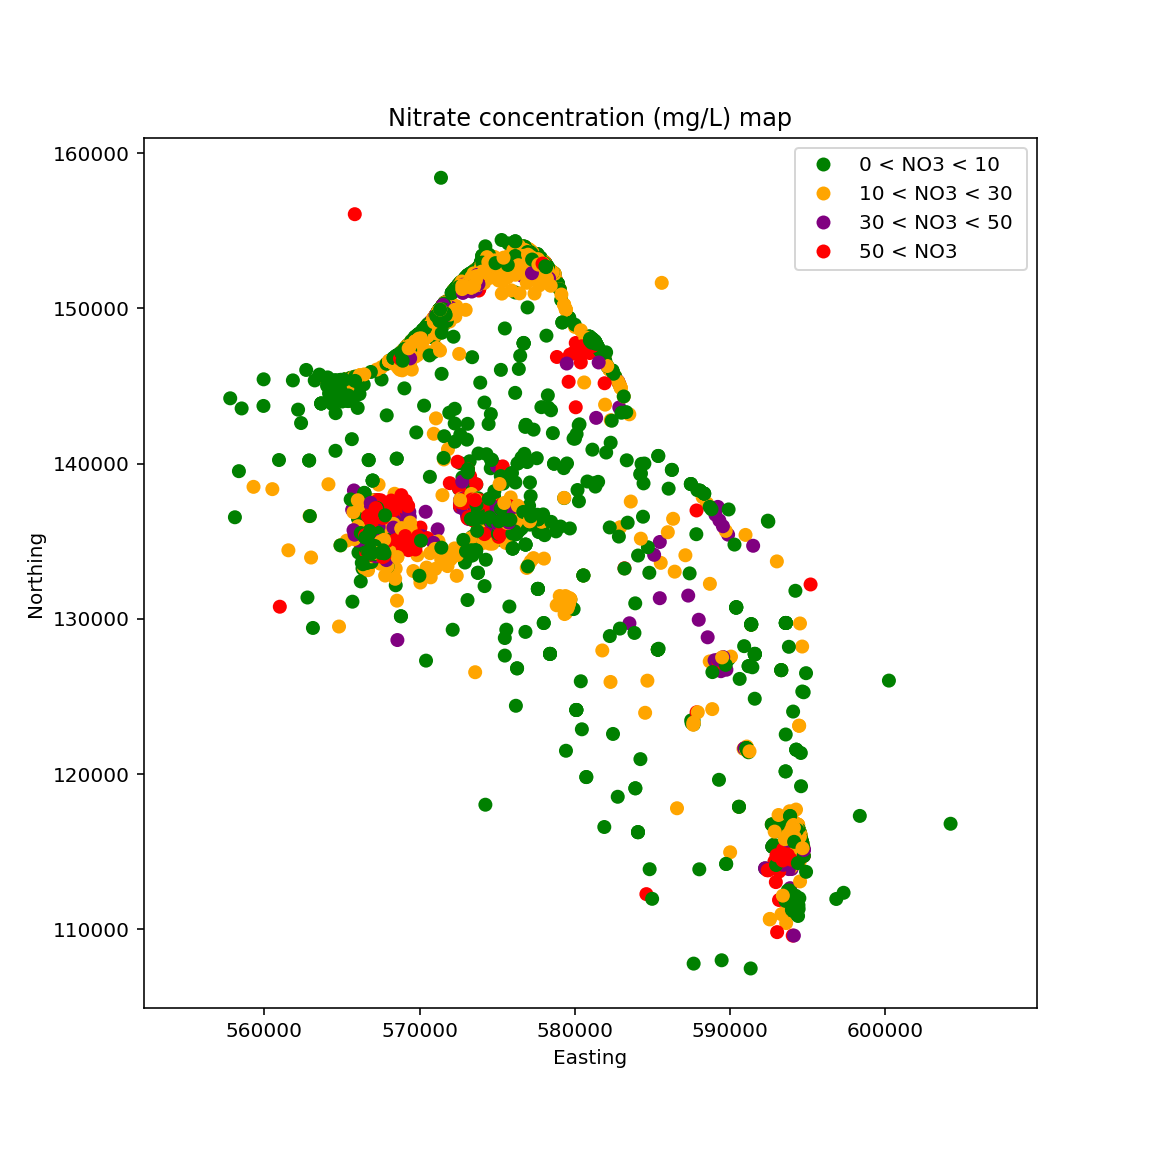

In [294]:
%matplotlib notebook

fig, ax1 = plt.subplots(1, 1)

# value = (nitrate_coord_agg['median'].values- nitrate_coord_agg['median'].min())/(nitrate_coord_agg['median'].max() \
#                                                                          - nitrate_coord_agg['median'].min())

medianCol = nitrate_coord_agg['median'].values /1000  

# color = ['green' if median <= 10 else 'red' for median in medianCol]

def colorcode(value):
    color = []
    for ivalue in value:
        if ivalue <= 10 :
            icolor = 'green'
        elif ivalue <= 30 :
            icolor = 'orange'
        elif ivalue <= 50 :
            icolor = 'purple'
        else:
            icolor = 'red'
        color.append(icolor)
    return color        
            

plt.scatter(nitrate_coord_agg['EASTING'].values, nitrate_coord_agg['NORTHING'].values, \
            color= colorcode(medianCol), marker= 'o')

# plt.scatter(nitrate_coord_agg['longitude'].values, nitrate_coord_agg['latitude'].values, \
#             color= colorcode(medianCol), marker= 'o')

ax1.set_ylabel('Northing')
ax1.set_xlabel('Easting')
ax1.set_title('Nitrate concentration (mg/L) map')
ax1.set_aspect("equal", "datalim")

legend_elements = [Line2D([0], [0], marker='o', color='w', label='0 < NO3 < 10 ',
                          markerfacecolor='g', markersize=8),
                   Line2D([0], [0], marker='o', color='w', label='10 < NO3 < 30 ',
                          markerfacecolor='orange', markersize=8),
                   Line2D([0], [0], marker='o', color='w', label='30 < NO3 < 50 ',
                          markerfacecolor='purple', markersize=8),
                    Line2D([0], [0], marker='o', color='w', label='50 < NO3 ',
                          markerfacecolor='r', markersize=8),
                    ]

ax1.legend(handles=legend_elements, loc='best')
fig.set_size_inches(8, 8)

# mplleaflet.display(fig=ax1)

## plot nitrate conc map using GeoPandas and show using `mplleaflet`

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/geopandas/plotting.py:389: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  "'color'.", UserWarning)


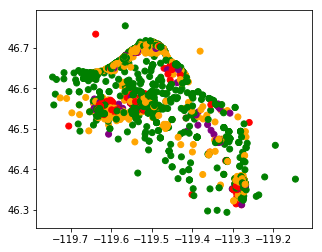

In [311]:
%matplotlib inline

geometry = [Point(xy) for xy in zip(nitrate_coord_agg.longitude, nitrate_coord_agg.latitude)]
crs = {'init': 'epsg:4326'}
geo_df = GeoDataFrame(nitrate_coord_agg, crs = crs, geometry = geometry)

ax = geo_df.plot(column = 'median', color = colorcode(medianCol))

In [315]:
# tile option: cartodb_positron

mplleaflet.show(fig=ax.figure, crs=geo_df.crs, tiles = 'cartodb_positron', path= 'nitrate_map.html')



## show well location using `Leaflet`

create GEOjson file to load into leaflet

In [245]:
nitrate_coord_agg = pd.read_csv(fname_GW_NO3_coord)

# create GEOjson file to load into leaflet
json_result_string = nitrate_coord_agg.to_json(
    orient='records', 
    double_precision=12,
    date_format='iso'
)
json_result = json.loads(json_result_string)

geojson = {
    'type': 'FeatureCollection',
    'features': []
}
for record in json_result:
    geojson['features'].append({
        'type': 'Feature',
        'geometry': {
            'type': 'Point',
            'coordinates': [record['longitude'], record['latitude']],  # GeoJSON need coord in long and lat order
        },
        'properties': record,
    })

# save json file
with open(fname_GW_NO3_geojson, 'w') as f:
    f.write(json.dumps(geojson, indent=2))

overlay wells on map

In [250]:
m = Map(center=(46.6, -119.5), zoom=10, layout = dict(width = '600px', height = '600px'),  basemap=basemaps.Esri.WorldImagery)

In [254]:
label = ipyw.Label(layout=ipyw.Layout(width='100%'))

In [253]:
with open(fname_GW_NO3_geojson, 'r') as f:
    data = json.load(f)
# for feature in data['features']:
#     feature['properties']['style'] = {
#         'color': 'grey',
#         'weight': 1,
#         'fillColor': 'grey',
#         'fillOpacity': 0.5
#     }
layer = GeoJSON(data=data, name='Nitrate')

def hover_handler(event=None, id=None, properties=None):
    label.value = properties['WellName']

layer.on_hover(hover_handler)

m.add_layer(layer)
# Adding the control# Addin 
m.add_control(LayersControl())

# plot groundwater level contour 

note: for plotting contour surface using plt.contour(X,Y,Z), Z must be shape of (ny, nx)

<IPython.core.display.Javascript object>


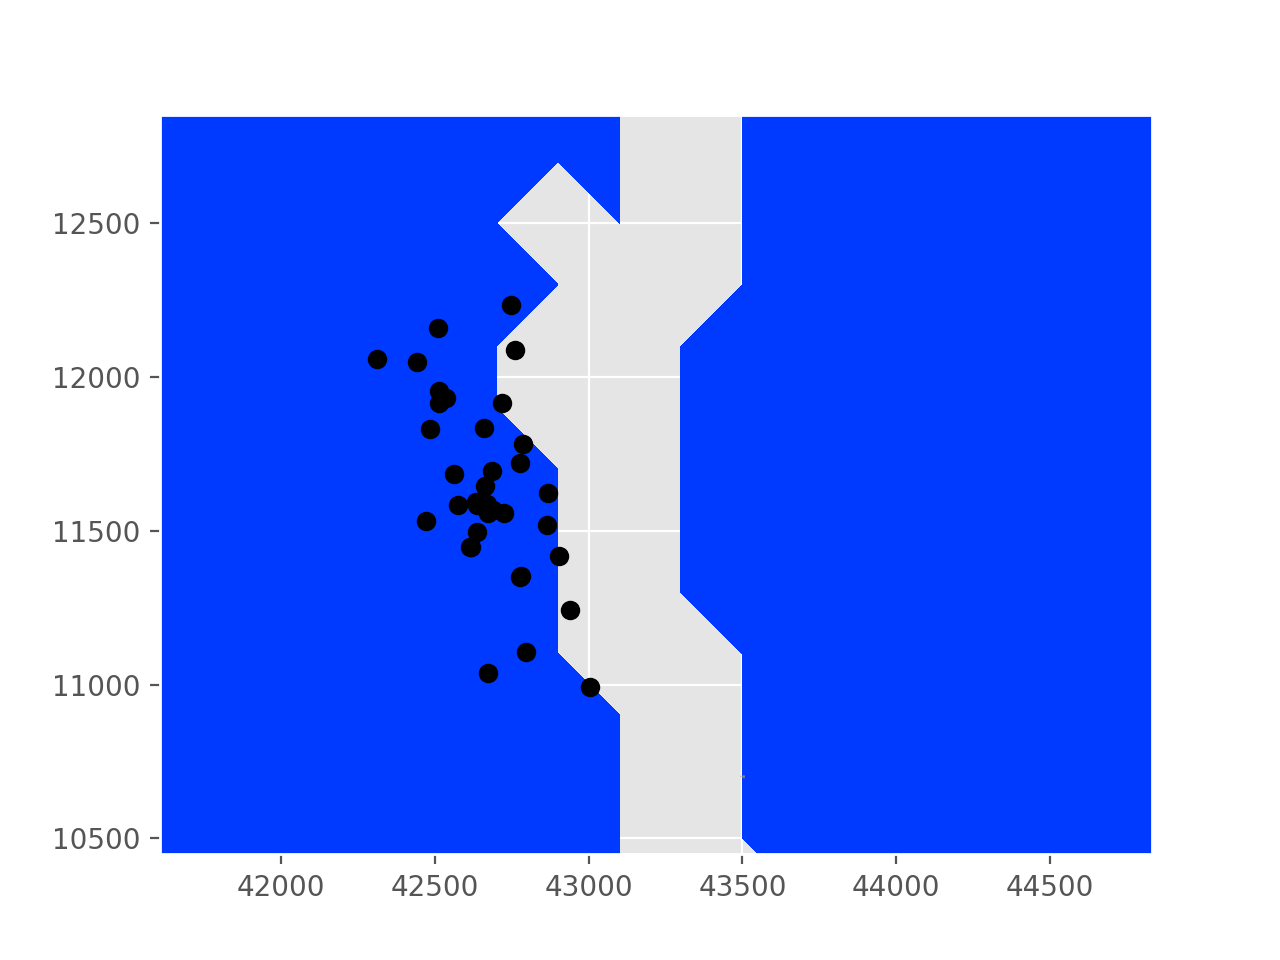

<a list of 62 text.Text objects>

In [256]:
iz = interval_index[-7]
fig = plt.figure()
gs = gridspec.GridSpec(1, 1)
ax1 = fig.add_subplot(gs[0, 0])
# plot contour
cf1 = ax1.contourf(x, y, temp_total_head[iz, :,:],
                   cmap=plt.cm.jet,
                   vmin=100,
                   vmax=130,
                   extend="both",
                   levels=np.arange(100, 130.1, 1)
                   )
# plot contour lines
cf2 = plt.contour(cf1, colors='grey', levels=np.arange(100, 130.1, 1))
ax1.set_aspect("equal", "datalim")

plt.plot(well_screen['Easting'], well_screen['Northing'], 'ko')
plt.clabel(cf2, inline = True, fmt = '%3.0d', fontsize = 10)
# plt.xlim(42000, 43000)
# plt.ylim(9000, 14000)

/Users/shua784/Paraview/HFR/HFR_200x200x2_1w_bc/pflotran_200x200x2_1w_bc.h5
Time:  3.24000E+04 h


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/contour.py:960: UserWarning: The following kwargs were not used by contour: 'V'
  s)


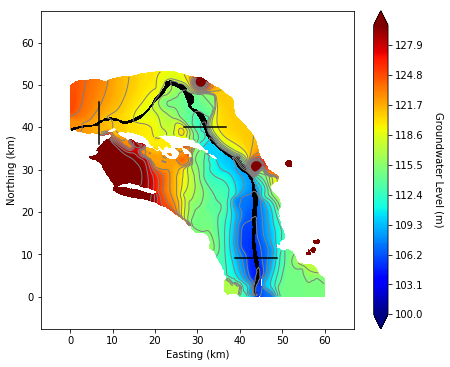

In [107]:
    fig_name = fig_wl + real_itime + ".png"
    gs = gridspec.GridSpec(1, 1)
    fig = plt.figure()
    ax1 = fig.add_subplot(gs[0, 0])
    ax1.plot(line1_x, line1_y, "black")
    ax1.plot(line2_x, line2_y, "black")
    ax1.plot(line3_x, line3_y, "black")
    cf1 = ax1.contourf(x / 1000, y / 1000, temp_wl,
                       cmap=plt.cm.jet,
                       levels=np.arange(100, 130.1, 0.1),
                       vmin=100,
                       vmax=130,
                       extend="both",
                       V=np.arange(100, 130.1, 5)
                       )
    cf2 = ax1.contour(x / 1000, y / 1000, temp_wl,
                      colors="grey",
                      levels=np.arange(100, 130.1, 1.5),
                      linewidths=1,
                      vmin=100,
                      vmax=130)

    ax1.set_xlabel("Easting (km)")
    ax1.set_ylabel("Northing (km)")
    ax1.set_aspect("equal", "datalim")
    ax1.set_xlim([np.min(x_grids) / 1000, np.max(x_grids) / 1000])
    ax1.set_ylim([np.min(x_grids) / 1000, np.max(x_grids) / 1000])
    ax1.set_aspect("equal", "datalim")
    cb1 = plt.colorbar(cf1, extend="both")  # ,
#                           orientation="horizontal", shrink=0.8, aspect=25)
    cb1.ax.set_ylabel("Groundwater Level (m)", rotation=270, labelpad=20)
    fig.tight_layout()
    cf3 = ax1.contourf(x / 1000, y / 1000, yx_river, colors="black")
    fig.set_size_inches(6.5, 5.5)

In [78]:
        fig.savefig(fig_name, dpi=600, transparent=True)
        plt.close(fig)
input_h5.close()